# Regression Exercise: Bike Sharing
## 1. Data Check

In [175]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

bike_df = pd.read_csv('../ExerciseWeek3/bike-sharing-demand/train.csv')
print(bike_df.shape) #as of today, 10886 records & 12 features/columns
bike_df.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [176]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [177]:
# Changing datetime object into datetime type
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)


# Assign year, month, day & hour
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x : x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


### After converting the object into datetime types,
### 4 more features were added (prev=12, now=16)

In [179]:
bike_df.shape

(10886, 16)

#### Deleting redundant data columns (Datetime, casual & registered)
#### count = casual + registered

In [181]:
drop_cols = ['datetime','casual','registered']
bike_df.drop(drop_cols, axis=1,inplace=True)
bike_df.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2


#### To evaluate regression models we use:
#### 1.Mean Squared Error
#### 2.Root mean squared error
#### 3.Mean absolute error
#### 4.Mean absolute percentage error

In [183]:
# Importing needed libraries for evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Scikit Learn doesn't offer Root Mean Squared Log Error
# Thus, we will manually define RMSLE

def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

In [184]:
# Defining RMSE
def rmse(y, pred):
    return np.sqrt(mean_squared_error(y,pred))

In [185]:
# MSE, RMSE, RMSLE
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)

    # MAE equation already exists in sklearn modules
    mae_val = mean_absolute_error(y,pred)

      # Print the values before formatting to check them
    print("RMSLE:", rmsle_val, "RMSE:", rmse_val, "MAE:", mae_val,'\n')
    
    print('RMSLE:{:.3f}, RMSE:{:.3f}, MAE:{:.3f}'.format(rmsle_val, rmse_val, mae_val))

## 2. Modelling
#### Using linear regression @ first

In [187]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test, pred)

RMSLE: 1.1646636237111023 RMSE: 140.8995886716559 MAE: 105.9244483510065 

RMSLE:1.165, RMSE:140.900, MAE:105.924


#### Apparently the erorr is a bit high considering the bike count we have
##### (ask papa about it visusally for more insight)

In [189]:
bike_df['count'].describe()

count    10886.000000
mean       191.574132
std        181.144454
min          1.000000
25%         42.000000
50%        145.000000
75%        284.000000
max        977.000000
Name: count, dtype: float64

#### As it can be seen, the avergae bike sharing use was 191 and median was 145
#### Comparing prediction with actual data

In [191]:
def get_top_error_data(y_test, pred, n_tops = 5):
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count']= np.round(pred)
    result_df['diff']= np.abs(result_df['real_count'] - result_df['predicted_count'])

    print(result_df.sort_values('diff', ascending=False)[:n_tops])

get_top_error_data(y_test, pred, n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


#### Precition gaps greater than 500 do not seem to fit the actual result

#### The reason for this is that the bike count was left biased
#### Left biased or Negatively Skewed

<Axes: >

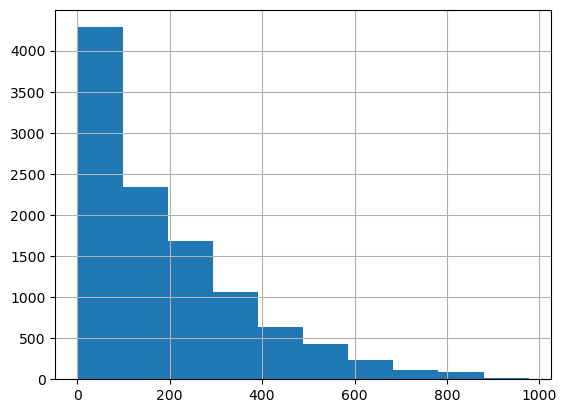

In [194]:
y_target.hist()

##### The x axis represents the bike sharing counts
##### The y axis represents the frquency of each count range
##### The data is heavily concentrated on the let side of the histogram, with the majority of counts being less than 200\
#### According to papa, given the majority of bike counts are under 200, a prediciton gap greater than 500 is unusual rare, counts above 500 are rare.
#### A large prediction gap in this range is likely an overestimate. Model needs more calibration, especially for lower or more common count values.

### Taking a log on our DV, why?
#### According to papa, this is to handle skewness, as previously seen, there was
#### left skewed data, this would help make the data more symmetrical
#### Other uses are, Stabilize Variance, Improve MOdel FIt

<Axes: >

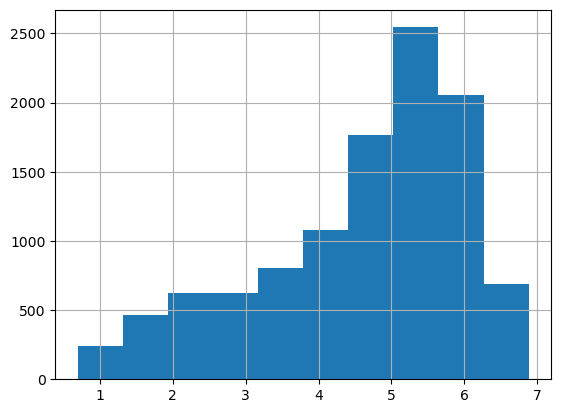

In [197]:
# np.log1p computes the natural logarithm of (1 + 'x')
# used to handle cases where x may be 0 or close to 0
# it ensures that the result is defined for all non-negative 'x'

y_log_transform = np.log1p(y_target)
y_log_transform.hist()

#### After this histogram, the variables seem to follow normalized distribution.
#### Thus, we will retrain the model now

In [199]:
y_target_log = np.log1p(y_target)

# np.log1p computes the natural logarithm of (1 + 'x')
# used to handle cases where x may be 0 or close to 0
# it ensures that the result is defined for all non-negative 'x'

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

y_test_exp = np.expm1(y_test)
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

RMSLE: 1.016826598200343 RMSE: 162.594268090046 MAE: 109.28615860077547 

RMSLE:1.017, RMSE:162.594, MAE:109.286


#### As seen in the results, the RMSLE score decreased, and the RMSE increased.
### But why?

## 3. Model Validation

### Taking a look on the features' coefficient
### Plotting coefficient

<Axes: ylabel='None'>

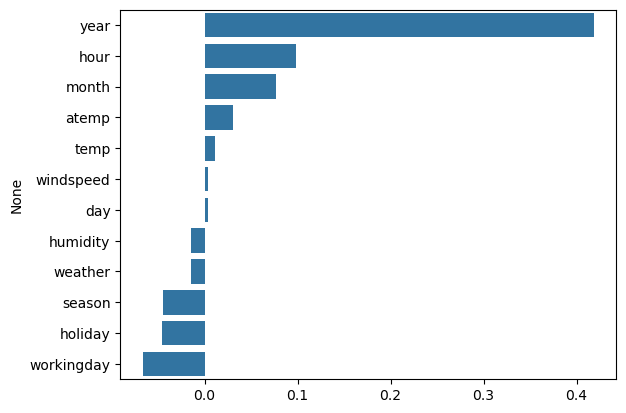

In [203]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

#### The features with the greatest coefficient are:
#### Datetime, including year, hour, month & day.

#### The data is only from year 2011 & 2012
#### Does not make sense to have such high coefficients
#### This is because such value is affecting the training.

#### Year & Day is just a date itself: year 2012 does not have greater value than year 2011
#### It's just a label 

### One Hot Encoding (year, month, day, hour)

In [207]:
X_features_ohe = pd.get_dummies(X_features, columns=['year', 'month', 'day', 'hour',
                                                     'holiday', 'workingday',
                                                     'season', 'weather'])

#### Retraining data after one hot encoding
### Modeling Ridge and Lasso

In [209]:
X_train, X_test, y_train, y_test = train_test_split( X_features_ohe, y_target_log,
                                                    test_size=0.3, random_state=0)

def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###', model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)
    # end of function

#Model Evaluation
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg,]:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

### LinearRegression ###
RMSLE: 0.5896394488215624 RMSE: 97.69048645285208 MAE: 63.3830878754745 

RMSLE:0.590, RMSE:97.690, MAE:63.383
### Ridge ###
RMSLE: 0.5901367703437248 RMSE: 98.52859077604572 MAE: 63.89335277110797 

RMSLE:0.590, RMSE:98.529, MAE:63.893
### Lasso ###
RMSLE: 0.6347518077052987 RMSE: 113.21881019147774 MAE: 72.80270669734962 

RMSLE:0.635, RMSE:113.219, MAE:72.803


#### If you compare it to the previous values:
#### Linear Regression: RMSLE:1.165, RMSE:140.900, MAE:105.924
#### After taking a log: RMSLE:1.017, RMSE:162.594, MAE:109.286
#### After hot encoding, ridge & lasso: RMSLE:0.635, RMSE:113.219, MAE:72.803

## Replotting the coefficient

<Axes: ylabel='None'>

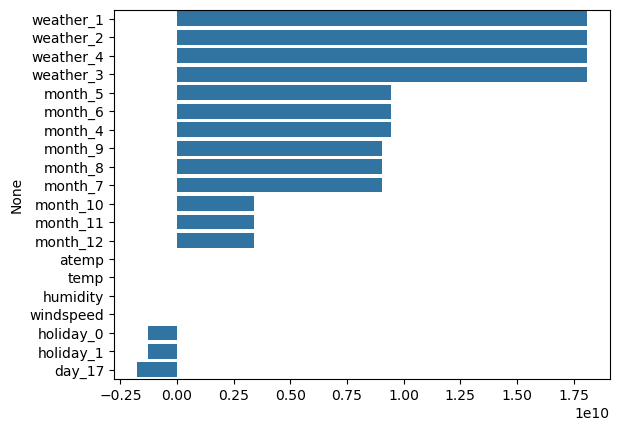

In [212]:
coef = pd.Series(lr_reg.coef_, index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

## Compare to previous Coefficient plot
### In a linear model, Feature Setup can drastically affect models

## TA bonus:
## Using ensemble models

In [215]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [216]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [217]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# RandomForest, GBM, XGBoost, LifhtGmb models
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    #XGBoost may troubleshoot if your input is DataFrame so assign them in ndarray
    get_model_predict(model, X_train.values, X_test.values, y_train.values,
                      y_test.values, is_expm1=True)

### RandomForestRegressor ###
RMSLE: 0.35479936793910155 RMSE: 50.525328848334816 MAE: 31.307091469426464 

RMSLE:0.355, RMSE:50.525, MAE:31.307
### GradientBoostingRegressor ###
RMSLE: 0.3298694957996135 RMSE: 53.34753109428186 MAE: 32.74781005331214 

RMSLE:0.330, RMSE:53.348, MAE:32.748
### XGBRegressor ###
RMSLE: 0.3387945101883576 RMSE: 51.475410497945525 MAE: 31.356582982001388 

RMSLE:0.339, RMSE:51.475, MAE:31.357
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 348
[LightGBM] [Info] Number of data points in the train set: 7620, number of used features: 72
[LightGBM] [Info] Start training from score 4.582043
### LGBMRegressor ###
RMSLE: 0.3188456499157369 RMSE: 47.21464677592674 MAE: 29.028770412428237 

RMSLE:0.319, RMSE:47.215, MAE:29.029


#### Compared to linear maodels, the DecisioTree & Ensemble models error is lower

#### However this does not mean that the model is perform better than linear models

### Pulling Feature Importances from the DecisionTree & Classification models

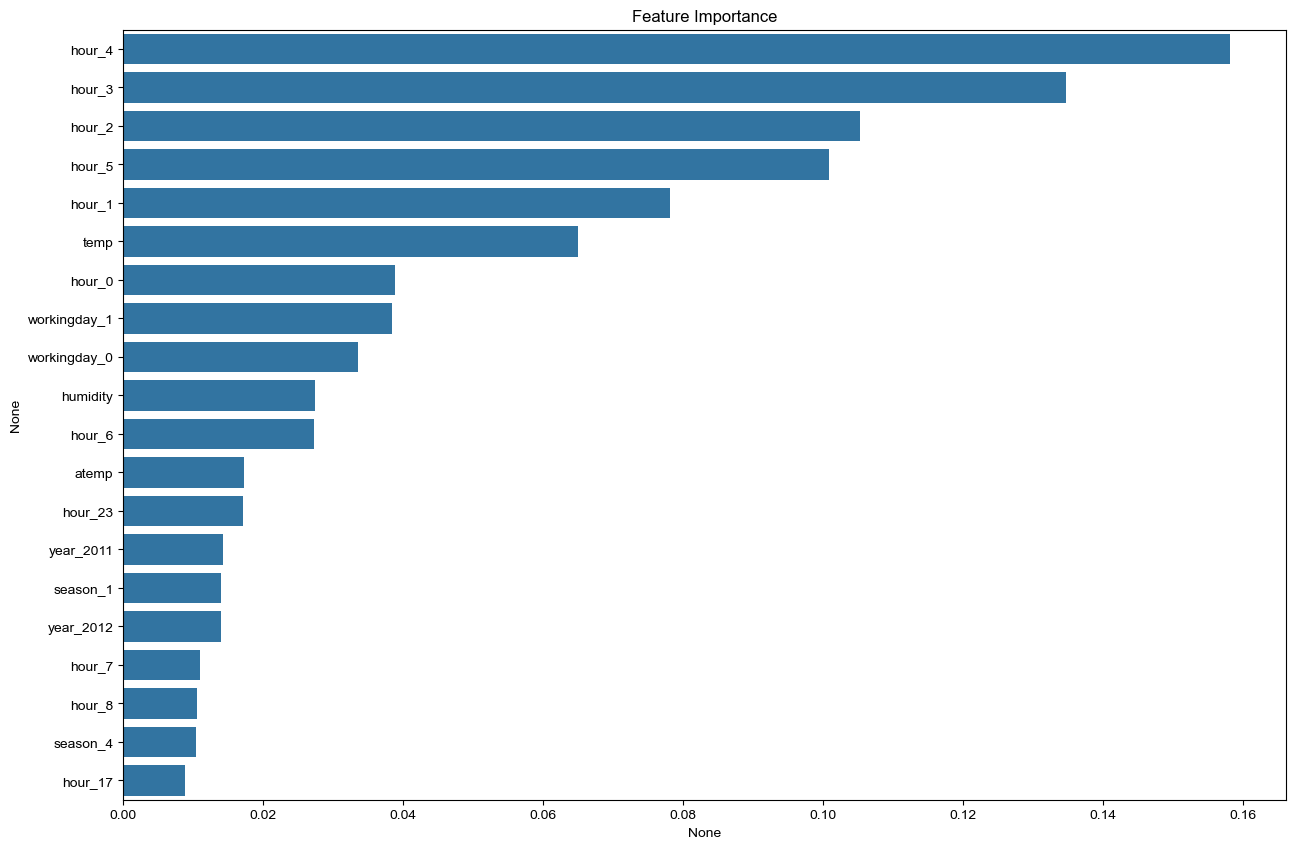

In [256]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/Arial.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

ftr_importances_values = rf_reg.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(15,10))
plt.title('Feature Importance')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
sns.set(font_scale=1.1)
plt.show()

#### The histogram shows the top 20 important features used by the RandomForestRegressor

##### hour_4, hour_3 & hour_2 are top 3 scores, the model relies on those specific hours when predicting the number of bike rentals
##### temp and humidity are also important features, weather conditions also impact bike usage (eg no rain or hot temperature makes people to use bikes)
##### working day / non working days also affect the number of rentals